In [ ]:
!pip install IPython

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
import scipy

In [ ]:
labels =[]
paths = []
for dirname, _, filenames in os.walk('SUBESCO/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-2] + filename.split('_')[-1]
        label = filename.split('_')[-2]
        labels.append(label.lower())
print('dataset loading complete')

dataset loading complete


In [ ]:
#creating a data frame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,SUBESCO/F_01_OISHI_S_10_ANGRY_1.wav,angry
1,SUBESCO/F_01_OISHI_S_10_ANGRY_2.wav,angry
2,SUBESCO/F_01_OISHI_S_10_ANGRY_3.wav,angry
3,SUBESCO/F_01_OISHI_S_10_ANGRY_4.wav,angry
4,SUBESCO/F_01_OISHI_S_10_ANGRY_5.wav,angry


In [ ]:
#feature extraction using MFCC-
def feature_extraction(filename, mfcc, chroma, mel):
    d, srate = librosa.load(filename, duration=3, offset=0.5)
    d=scipy.signal.wiener(d)
    if chroma:
        stft = np.abs(librosa.stft(d))
        stft= librosa.amplitude_to_db(stft)
    result = np.array([])
    if mfcc:
        mfccr = np.abs(np.mean(librosa.feature.mfcc(d, sr=srate, n_mfcc=23).T, axis=0))
        result = np.hstack((result, mfccr))
    if chroma:
        chroma = np.abs(np.mean(librosa.feature.chroma_stft(S=stft, sr=srate).T, axis=0))
        result = np.hstack((result, chroma))
    if mel:
        mel= np.mean(librosa.feature.melspectrogram(d, sr=srate, n_mels=40).T, axis=0)
        mel = np.abs(librosa.power_to_db(mel))
        result = np.hstack((result, mel))
    return result


In [ ]:
p=[feature_extraction(df['speech'][0], mfcc=True, chroma=True, mel=True)]
np.array(p)


array([[1.57808637e+02, 7.20476797e+01, 1.12137017e+01, 1.71529251e+01,
        4.02481386e-01, 2.02619339e+00, 2.90358293e+00, 5.91999467e+00,
        5.09802873e+00, 8.65040254e-01, 2.74390924e+00, 4.17027529e+00,
        1.36155973e+00, 6.69072583e-01, 3.10519883e+00, 3.49791117e+00,
        2.26512739e+00, 2.31283607e+00, 2.82023226e+00, 9.91639352e-01,
        1.20523873e+00, 1.23389252e+00, 5.27648686e+00, 7.49478991e-02,
        1.31466609e-01, 1.85755776e-01, 1.80768686e-01, 1.73390973e-01,
        9.11324158e-02, 1.49379427e-02, 2.61438862e-02, 2.32865749e-04,
        2.10804511e-02, 4.72276354e-02, 5.01801436e-02, 6.53717953e+00,
        1.41970466e+01, 2.21735475e+01, 2.11231019e+01, 1.80776107e+01,
        1.95261605e+01, 2.06912832e+01, 1.95371887e+01, 1.42655738e+01,
        1.53605605e+01, 1.60859566e+01, 1.11288477e+01, 8.92768297e+00,
        1.26582730e+01, 1.04214744e+01, 8.12316226e+00, 1.26003335e+01,
        1.16143275e+01, 8.40248529e+00, 7.63023873e+00, 5.660839

In [ ]:
X_features= df['speech'].apply(lambda x: feature_extraction(x, mfcc=True, chroma=True, mel=True))

In [ ]:
#X-mfcc is in dataframe structure.. convert it into 2D array
X=[x for x in X_features]
np.array(X).shape

(7000, 75)

# MLP Classifier

In [ ]:
df_shuffle=df.sample(frac=1)
y_mlp = df['label'].to_numpy()
print(y_mlp)

['angry' 'angry' 'angry' ... 'surprise' 'surprise' 'surprise']


In [ ]:
#  train set and test set for LSTM Model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y_mlp, test_size=0.15) # convert X to array

In [ ]:
# Disigning the network according the best parameters results
from sklearn.neural_network import MLPClassifier

model4= MLPClassifier(alpha=0.01, activation='relu', batch_size=256, hidden_layer_sizes=(300,150,100), solver='adam', learning_rate='adaptive', max_iter=1000)
model4.fit(X_train, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300, 150, 100),
              learning_rate='adaptive', max_iter=1000)

In [ ]:
#prediction on the model and different analysis parameter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = model4.predict(X_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_test, y_pred))


Accuracy: 80.38%
[[137   5   1   6   0   3   6]
 [ 13 137  10  28   2   7  22]
 [  1   1 127   3   1  19   7]
 [  1  10   1 104   0   1   1]
 [  1   0   2   3 124   8   0]
 [  1   0   4   5   6 109   0]
 [  4   8   4   8   0   3 106]]
              precision    recall  f1-score   support

       angry       0.87      0.87      0.87       158
     disgust       0.63      0.85      0.72       161
        fear       0.80      0.85      0.82       149
       happy       0.88      0.66      0.76       157
     neutral       0.90      0.93      0.92       133
         sad       0.87      0.73      0.79       150
    surprise       0.80      0.75      0.77       142

    accuracy                           0.80      1050
   macro avg       0.82      0.81      0.81      1050
weighted avg       0.82      0.80      0.80      1050



Accuracy Score: 80.38%
[[137  13   1   1   1   1   4]
 [  5 137   1  10   0   0   8]
 [  1  10 127   1   2   4   4]
 [  6  28   3 104   3   5   8]
 [  0   2   1   0 124   6   0]
 [  3   7  19   1   8 109   3]
 [  6  22   7   1   0   0 106]]
              precision    recall  f1-score   support

       angry       0.87      0.87      0.87       158
     disgust       0.63      0.85      0.72       161
        fear       0.80      0.85      0.82       149
       happy       0.88      0.66      0.76       157
     neutral       0.90      0.93      0.92       133
         sad       0.87      0.73      0.79       150
    surprise       0.80      0.75      0.77       142

    accuracy                           0.80      1050
   macro avg       0.82      0.81      0.81      1050
weighted avg       0.82      0.80      0.80      1050



(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

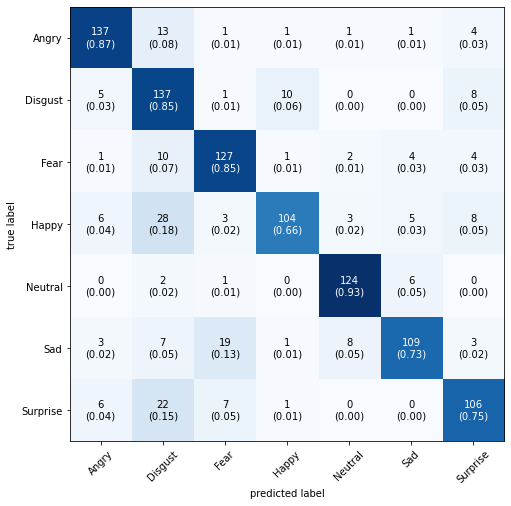

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, classification_report


accuracy= accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: {:.2f}%".format(accuracy*100))
print(confusion_matrix(y_true=y_test, y_pred=y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))

class_names=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(8,8), class_names=class_names, show_normed=True)